# CMIST Hiring Exercise - ML+CV Engineer

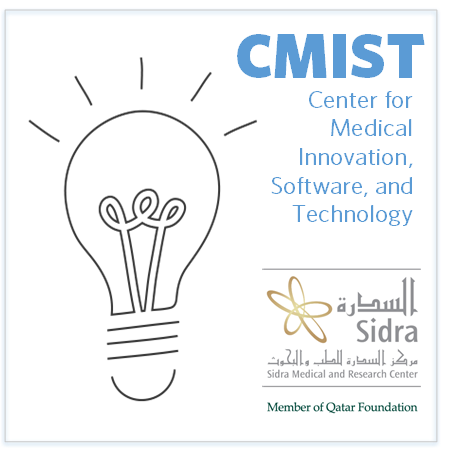

## Aim of the Project: 

Create a model which can be used to recognize and annotate cats in photos. Any training set available online can be used to train the model. Two scripts to be submitted: one to train the model and one which applies the model onto our test set of images (test_set.zip) and draws bounding boxes around cats on the test set as such:


### Package Requirements:
numpy (pip install numpy) tqdm (pip install tqdm)
CPU version of TensorFlow, just do pip install tensorflow To install the GPU version of TensorFlow, you need to get all the dependencies and such.

### Approach

This is an Object Detection Problem which can be approached as either a classification problem or a regression problem.
As a classification problem, the image are divided into small patches, each of which will be run through a classifier 
to determine whether there are objects in the patch. Then the bounding boxes will be assigned to locate around patches that 
are classified with high probability of present of an object. In the regression approach, the whole image will be run through
a convolutional neural network to directly generate one or more bounding boxes for objects in the images.


In [1]:
import cv2
import numpy as np
import os                  # dealing with directories
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

Target_path='/test_images/'

Using TensorFlow backend.


In [2]:
# Pre trained weights require this ordering
keras.backend.set_image_dim_ordering('th')

def get_model():
    model = Sequential()
    
    # Layer 1
    model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 2
    model.add(Convolution2D(32,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 3
    model.add(Convolution2D(64,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 4
    model.add(Convolution2D(128,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 5
    model.add(Convolution2D(256,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 6
    model.add(Convolution2D(512,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 7
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 8
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 9
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    model.add(Flatten())
    
    # Layer 10
    model.add(Dense(256))
    
    # Layer 11
    model.add(Dense(4096))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 12
    model.add(Dense(1470))
    
    return model

In [3]:
# Preprocessing

def crop_and_resize(image):
    cropped = image[:,:,:]
    return cv2.resize(cropped, (448,448))

def normalize(image):
    normalized = 2.0*image/255.0 - 1
    return normalized

def preprocess(image):
    cropped = crop_and_resize(image)
    normalized = normalize(cropped)
    # The model works on (channel, height, width) ordering of dimensions
    transposed = np.transpose(normalized, (2,0,1))
    return transposed

In [4]:


class Box:
    def __init__(self):
        self.x, self.y = float(), float()
        self.w, self.h = float(), float()
        self.c = float()
        self.prob = float()
        
def overlap(x1, w1, x2, w2):
    l1 = x1 - w1 / 2.
    l2 = x2 - w2 / 2.
    left = max(l1, l2)
    r1 = x1 + w1 / 2.
    r2 = x2 + w2 / 2.
    right = min(r1, r2)
    return right - left


def box_intersection(a, b):
    """

    :param a: Box 1
    :param b: Box 2
    :return: Intersection area of the 2 boxes
    """
    w = overlap(a.x, a.w, b.x, b.w)
    h = overlap(a.y, a.h, b.y, b.h)
    if w < 0 or h < 0:
        return 0
    area = w * h
    return area


def box_union(a, b):
    """

    :param a: Box 1
    :param b: Box 2
    :return: Area under the union of the 2 boxes
    """
    i = box_intersection(a, b)
    u = a.w * a.h + b.w * b.h - i
    return u


def box_iou(a, b):
    """

    :param a: Box 1
    :param b: Box 2
    :return: Intersection over union, which is ratio of intersection area to union area of the 2 boxes
    """
    return box_intersection(a, b) / box_union(a, b)



def yolo_output_to_cat_boxes(yolo_output, threshold=0.2, sqrt=1.8, C=20, B=2, S=7):

    # Position for class 'car' in the VOC dataset classes
    cat_class_number = 7

    boxes = []
    SS = S*S  # number of grid cells
    prob_size = SS*C  # class probabilities
    conf_size = SS*B  # confidences for each grid cell

    probabilities = yolo_output[0:prob_size]
    confidence_scores = yolo_output[prob_size: (prob_size + conf_size)]
    cords = yolo_output[(prob_size + conf_size):]

    # Reshape the arrays so that its easier to loop over them
    probabilities = probabilities.reshape((SS, C))
    confs = confidence_scores.reshape((SS, B))
    cords = cords.reshape((SS, B, 4))

    for grid in range(SS):
        for b in range(B):
            bx = Box()

            bx.c = confs[grid, b]

            # bounding box xand y coordinates are offsets of a particular grid cell location,
            # so they are also bounded between 0 and 1.
            # convert them absolute locations relative to the image size
            bx.x = (cords[grid, b, 0] + grid % S) / S
            bx.y = (cords[grid, b, 1] + grid // S) / S


            bx.w = cords[grid, b, 2] ** sqrt
            bx.h = cords[grid, b, 3] ** sqrt

            # multiply confidence scores with class probabilities to get class sepcific confidence scores
            p = probabilities[grid, :] * bx.c

            # Check if the confidence score for class 'car' is greater than the threshold
            if p[cat_class_number] >= threshold:
                bx.prob = p[cat_class_number]
                boxes.append(bx)

    # combine boxes that are overlap

    # sort the boxes by confidence score, in the descending order
    boxes.sort(key=lambda b: b.prob, reverse=True)


    for i in range(len(boxes)):
        boxi = boxes[i]
        if boxi.prob == 0:
            continue

        for j in range(i + 1, len(boxes)):
            boxj = boxes[j]

            # If boxes have more than 40% overlap then retain the box with the highest confidence score
            if box_iou(boxi, boxj) >= 0.4:
                boxes[j].prob = 0

    boxes = [b for b in boxes if b.prob > 0]

    return boxes


def draw_boxes(boxes,im, crop_dim):
    imgcv1 = im.copy()
    [xmin, xmax] = crop_dim[0]
    [ymin, ymax] = crop_dim[1]
    
    height, width, _ = imgcv1.shape
    for b in boxes:
        w = xmax - xmin
        h = ymax - ymin

        left  = int ((b.x - b.w/2.) * w) + xmin
        right = int ((b.x + b.w/2.) * w) + xmin
        top   = int ((b.y - b.h/2.) * h) + ymin
        bot   = int ((b.y + b.h/2.) * h) + ymin

        if left  < 0:
            left = 0
        if right > width - 1:
            right = width - 1
        if top < 0:
            top = 0
        if bot>height - 1: 
            bot = height - 1
        
        thick = 5 #int((height + width // 150))
        
        cv2.rectangle(imgcv1, (left, top), (right, bot), (255,0,0), thick)

    return imgcv1

In [5]:

def load_weights(model, yolo_weight_file):
    data = np.fromfile(yolo_weight_file, np.float32)
    data = data[4:]

    index = 0
    for layer in model.layers:
        shape = [w.shape for w in layer.get_weights()]
        if shape != []:
            kshape, bshape = shape
            bia = data[index:index + np.prod(bshape)].reshape(bshape)
            index += np.prod(bshape)
            ker = data[index:index + np.prod(kshape)].reshape(kshape)
            index += np.prod(kshape)
            layer.set_weights([ker, bia])

In [6]:
# Load weights
model = get_model()
load_weights(model,'yolo-tiny.weights')

In [16]:
test_image = mpimg.imread('test_images/test (70).jpg')
pre_processed = preprocess(test_image)
batch = np.expand_dims(pre_processed, axis=0)
batch_output = model.predict(batch)
print(batch_output.shape)

(1, 1470)


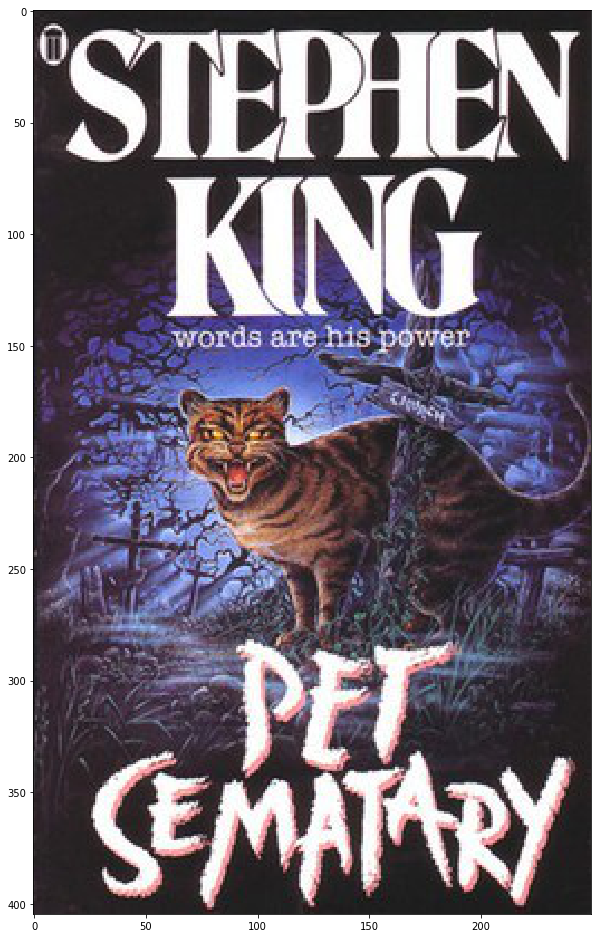

In [17]:
plt.imshow(test_image)

In [18]:
batch_output

array([[ 0.04692038,  0.01078258,  0.02810637, ...,  0.32797393,
         0.23722406,  0.36333984]], dtype=float32)

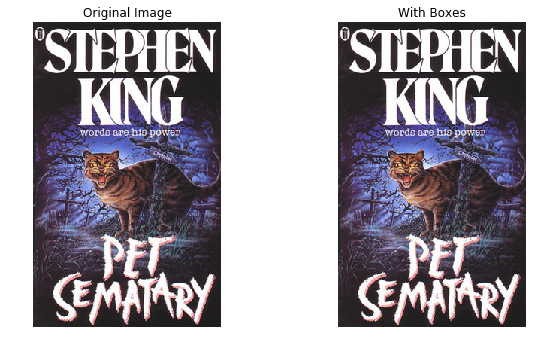

In [19]:
boxes = yolo_output_to_cat_boxes(batch_output[0], threshold=0.1)
final = draw_boxes(boxes, cv2.resize(test_image, (448,448)), ((1,test_image.shape[1]),(1,test_image.shape[0])))

plt.rcParams['figure.figsize'] = (10, 5.6)
plt.subplot(1,2,1)
plt.imshow(test_image)
plt.axis('off')
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(test_image)
plt.axis('off')
plt.title("With Boxes")

In [21]:
# Final pipeline
def pipeline(image):
    pre_processed = preprocess(image)
    batch = np.expand_dims(pre_processed, axis=0)
    batch_output = model.predict(batch)
    boxes = yolo_output_to_cat_boxes(batch_output[0], threshold=0.20)
    final = draw_boxes(boxes,image, ((0,image.shape[1]),(0,image.shape[0])))
    return final

In [ ]:
filenames = glob.glob("test_images/*.jpg")
num_files = len(filenames)

plt.rcParams['figure.figsize'] = (10, 20)

for i in range(num_files):
    image = mpimg.imread(filenames[i])
    image = cv2.resize(image, (448,448))
    final = pipeline(image)
    mpimg.imsave("output_images/test%d.jpg" % (i+1), final)
    
    #plt.subplot(num_files,2,i*2+1)
    #plt.imshow(image)
    #plt.axis('off')
    #plt.title("Test Image %d" % (i+1))
    #plt.subplot(num_files,2,i*2+2)
    #plt.imshow(final)
    #plt.axis('off')
    #plt.title("Output %d" % (i+1))

